In [1]:
%matplotlib inline
import os
import tqdm
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import transforms

from src.utils.easyparser import *
from src.utils.visulize import plot_input
from src.utils.loss import Loss
from src.dataseters.GRUs import TyDataset, ToTensor, Normalize
from src.operators.transformer import *

##### Get args

In [2]:
settings = parser()
# print(settings.initial_args)
settings.initial_args.gpu = 0
settings.initial_args.I_size = 120
settings.initial_args.F_size = 120
settings.initial_args.batch_size = 5
args = settings.get_args()

#### Make some settings
1. Set gpu device
2. Set torch's and numpy's manual seed

In [3]:
torch.cuda.set_device(args.gpu)
np.random.seed(args.seed)
torch.manual_seed(args.seed)
torch.cuda.manual_seed(args.seed)

##### Make dataloaders for training and validating

In [4]:
# set transform tool for datasets
if args.normalize_input:
    transform = transforms.Compose([ToTensor(), Normalize(args)])
else:
    transform = transforms.Compose([ToTensor()])
    
# training and validating data
trainset = TyDataset(args, train=True, transform=transform)
valiset = TyDataset(args, train=False, transform=transform)

# dataloader
train_kws = {'num_workers': 4, 'pin_memory': True} if args.able_cuda else {}
test_kws = {'num_workers': 4, 'pin_memory': True} if args.able_cuda else {}

trainloader = DataLoader(dataset=trainset, batch_size=args.batch_size, shuffle=True, **train_kws)
valiloader = DataLoader(dataset=valiset, batch_size=args.batch_size, shuffle=False, **test_kws)

In [5]:
# inputs = torch.Size([6, 1, 120, 120])
# height = torch.Size([120, 120])
# targets = torch.Size([18, 120, 120])
# ty_infos = torch.Size([24, 3])
# for i in range(len(trainset)):
#     if trainset[i]['inputs'].shape != inputs:
#         print(trainset[i]['inputs'].shape)
#     if trainset[i]['height'].shape != height:
#         print(trainset[i]['height'].shape)
#     if trainset[i]['targets'].shape != targets:
#         print(trainset[i]['targets'].shape)
#     if trainset[i]['ty_infos'].shape != ty_infos:
#         print(trainset[i]['ty_infos'].shape)

##### Print and visulize data

In [6]:
# for idx, data in enumerate(trainloader):
#     src = data['inputs'].to(device=args.device)
#     tgt = data['targets'].to(device=args.device).unsqueeze(2)
#     if (idx+1) % 10 == 0:
#         print('{:d}/{:d}'.format(idx+1, len(trainloader)))
# args.figure_dpi = 80
# plot_input(args=args, x=a['inputs'][0], current_time=a['current_time'][0])

#### Test transformer

In [7]:
model = make_model(H=args.I_size, W=args.I_size, input_channel=1, d_channel=5, d_channel_ff=10) \
                    .to(device=args.device, dtype=args.value_dtype)

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


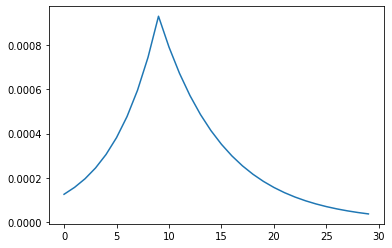

In [8]:
optimizer = torch.optim.Adam(model.parameters(), lr=args.lr, weight_decay=args.weight_decay)
lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=1.25)
lr = []
for i in range(30):
    if i >= 10:
        lr_scheduler.gamma = 0.85
    lr_scheduler.step()
    lr.append(optimizer.param_groups[0]['lr'])
plt.plot(lr)

In [9]:
def train_epoch(model, dataloader, optimizer, args):
    model.train()
    
    tmp_loss = 0
    total_loss = 0
    device = args.device
    dtype = args.value_dtype
    loss_function = args.loss_function
    
    total_idx = len(dataloader)
    
    for idx, data in enumerate(dataloader,0):
        src = data['inputs'].to(device=device,dtype=dtype)
        tgt = data['targets'].to(device=device,dtype=dtype).unsqueeze(2)
        src_mask = torch.ones(1, src.shape[1]).to(device=device,dtype=dtype)
        tgt_mask = subsequent_mask(tgt.shape[1]).to(device=device,dtype=dtype)
        pred = model(src, tgt, src_mask, tgt_mask)
        
        optimizer.zero_grad()
        
        loss = loss_function(pred, tgt.squeeze(2))
        loss.backward()
        
        optimizer.step()
        
        tmp_loss += loss.item()/200
        total_loss += loss.item()/total_idx
        
        if (idx+1) % 100 == 0:
            print('{:d}/{:d}: Loss: {:.2f}'.format(idx+1, total_idx, tmp_loss))
            tmp_loss = 0
            
    return total_loss

In [ ]:
lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=1.25)
trainloss_df = pd.DataFrame([],index=pd.Index(range(args.max_epochs), name='Epoch'), columns=['Train_loss'])
for epoch in range(args.max_epochs):
    if i >= 10:
        lr_scheduler.gamma = 0.85
    lr_scheduler.step()
    lr = optimizer.param_groups[0]['lr']
    print('Learning rate: {}'.format(lr))
    
    trainloss_df.iloc[epoch] = train_epoch(model, trainloader, optimizer, args)
    print('Epoch {:03d}: Loss= {:.2f}'.format(epoch, trainloss_df.iat[epoch,0]))

Learning rate: 8.5e-05
